In [59]:
!pip install pandas tqdm
!pip install matplotlib seaborn

You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# CORD-19 References

Este notebook explora la calidad de las referencias contenidas en el COVID-19 Open Research Dataset Challenge.
Las respuestas que se intentan responder son:

- Cuántos papers tiene el dataset?
- Cuántos papers del dataset tienen referencia?
- Cuántas referencias hace cada paper?
- Cuántas referencias que se hacen están dentro del conjunto de datos? Cuántas referencias que se hacen están fuera?

In [2]:
# En primer lugar, se cargará el conjunto de datos.
# Se debe extraer el conjunto de datos en una carpeta `datasets`.

import pandas as pd


DATASET_FOLDER_PATH = "./datasets/CORD-19-research-challenge"
metadata_df = pd.read_csv(f"{DATASET_FOLDER_PATH}/metadata.csv", index_col="cord_uid")
metadata_df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
cord_uid,,,,,,,,,,,,,,,,,
xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [3]:
# Veamos la cantidad de registros y columnas del archivo de metadatos
metadata_df.columns, len(metadata_df)

(Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
        'abstract', 'publish_time', 'authors', 'journal',
        'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
        'has_pmc_xml_parse', 'full_text_file', 'url'],
       dtype='object'),
 51078)

**Se observan 51.078 registros**, cada uno representando un paper
Además del identificador único `cord_uid`, se observan las siguientes columnas:

- `sha`: hash del PDF
- `source_x`: repositorio fuente, e.g. biorxiv, Elsevier, etc.
- `title`: título del paper
- `doi`, `pmcid`, `pubmed_id`, `Microsoft Academic Paper ID`, `WHO #Covidence`: identificadores asociados al paper
- `license`: licencia de uso
- `abstract`: resumen en lenguaje natural
- `publish_time`: fecha de publicación
- `journal`: en el caso de haber sido publicado en uno, el nombre del journal
- `authors`: autores en lenguaje natural
- `has_pdf_parse`: si el paper tiene parseado su PDF o no
- `has_pmc_xml_parse`: si el XML de PubMed del paper está parseado o no
- `full_text_file`
- `url`: enlace al paper

A continuación se revisará la estructura de carpetas y archivos del conjunto de datos.

In [4]:
import json
import random
import os

def _sample_json_file(path):
    for _, _, file_names in os.walk(path):
        sample_file_name = random.choice(file_names)
        file_path = os.path.join(path, sample_file_name)
        with open(file_path) as file:
            contents = json.load(file)
        return list(contents.keys())

def walk_dataset():
    cum_sum = 0
    for root, folders, files in os.walk(DATASET_FOLDER_PATH):
        num_folders = len(folders)
        num_files = len(files)
        if "json" in root and num_folders == 0 and num_files > 0:
            cum_sum += num_files
            print(f"{root}: {num_files} files")
    return cum_sum

walk_dataset()

./datasets/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json: 1625 files
./datasets/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json: 2490 files
./datasets/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pmc_json: 2217 files
./datasets/CORD-19-research-challenge/custom_license/custom_license/pdf_json: 26505 files
./datasets/CORD-19-research-challenge/custom_license/custom_license/pmc_json: 7802 files
./datasets/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json: 9524 files
./datasets/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pmc_json: 9148 files


59311

Se observan 59.311 archivos, lo que arroja una diferencia de 8.233 respecto a la cantidad de registros en el CSV de metadatos.
Probablemente, existen registros en el CSV de metadatos que tienen más de un archivo.

De acuerdo a la información encontrada en la comunidad de Kaggle, existen al menos dos procedimientos recomendados para cargar los datos.

```python
# Primer procedimiento
for row in metadata_file:
    pmc_id = row["pmc_id"]
    if exists pmc_id file in pmc_jsons subfolders:
        return pmc_id file
    # Si pmc_id es nulo o no existe archivo
    sha = row["sha"]
    if exists sha file in pdf_jsons subfolders:
        return sha file

# Segundo procedimiento
for pdf file in pdf files:
    if pdf file sha not in metadata_file shas:
        continue
    else:
        row = metadata_file row with matching pdf file sha
        pmc_id = row["pmc_id"]
        if exists pmc_id file in pmc_jsons subfolders:
            return pmc_id file
        return pdf file
```

In [5]:
# 1. Construir diccionarios de PMC files, JSON files
# 2. Iterate metadata file

def get_id_paths_dicts(cls):
    """
    Esta función construye los diccionarios cuyas llaves son identificadores
    de alguna clase de papers (PDF o PMC) y cuyos valores son los paths hacia
    los archivos asociados.
    """
    all_files = {}
    for root, folders, files in os.walk(DATASET_FOLDER_PATH):
        num_folders = len(folders)
        num_files = len(files)
        if cls in root and num_folders == 0 and num_files > 0:
            for file_name in files:
                _id = file_name.split(".")[0]
                all_files[_id] = os.path.join(root, file_name)
    return all_files

In [6]:
pdf_dict = get_id_paths_dicts("pdf")
pmc_dict = get_id_paths_dicts("pmc")
len(pdf_dict), len(pmc_dict)

(40144, 19167)

Se observa la existencia de:

- 40.144 archivos PDF con sus respectivos JSONs
- 19.167 archivos PMC con sus respectivos JSONs

En base a la información anterior, se seguirá el primer procedimiento para cargar los papers.

In [7]:
from tqdm.notebook import tqdm


class BasePaper:
    def __init__(self, metadata_row, file_path):
        self._metadata_row = metadata_row
        self._file_path = file_path
        self._file_contents = self._load_json_contents(file_path)
        
        self._referenced_by = []
        self._references = []
        
    @staticmethod
    def _load_json_contents(path):
        with open(path) as file:
            contents = json.load(file)
        return contents

    @property
    def title(self):
        return self._metadata_row["title"]
        
    @property
    def authors(self):
        return self._metadata_row["authors"]
        
    @property
    def publish_time(self):
        return self._metadata_row["publish_time"]
        
    @property
    def abstract(self):
        return self._metadata_row["abstract"]
        
    @property
    def bib_entries(self):
        return self._file_contents["bib_entries"]
    
    def register_reference(self, reference):
        self._references.append(reference)
        reference.register_referenced(self)
    
    def register_referenced(self, referenced):
        self._referenced_by.append(referenced)
    
    
class PDFPaper(BasePaper):
    pass
        

class PMCPaper(BasePaper):
    pass

def load_papers(metadata_df):
    papers = []
    not_found = []
    for idx, row in tqdm(metadata_df.iterrows()):
        pmc_id = row["pmcid"]
        shas = row["sha"]
        paper = None
        
        if pmc_id in pmc_dict:
            pmc_path = pmc_dict[pmc_id]
            paper = PMCPaper(row, pmc_path)
            
        if paper is None and pd.notna(shas):
            shas_splitted = shas.split("; ")
            for sha in shas_splitted:
                if sha in pdf_dict:
                    pdf_path = pdf_dict[sha]
                    paper = PDFPaper(row, pdf_path)
                    break
        
        if paper is None and (row["has_pdf_parse"] or row["has_pmc_xml_parse"]):
            not_found.append(idx)
        if paper is not None:
            papers.append(paper)
            
    return papers, not_found

papers, not_found = load_papers(metadata_df)
len(papers), len(not_found)

(38882, 0)

In [8]:
mask_1 = metadata_df["has_pdf_parse"]
mask_2 = metadata_df["has_pmc_xml_parse"]
(mask_1 | mask_2).sum()

38882

Somos capaces de identificar los archivos JSONs de 38.882 registros del archivo de metadatos.
Es consistente con que solo 38.882 registros del archivo de metadatos tiene parseado PDF o PMC.

In [9]:
paper = papers[0]
paper.title, paper.authors, paper.abstract

('Airborne rhinovirus detection and effect of ultraviolet irradiation on detection by a semi-nested RT-PCR assay',
 'Myatt, Theodore A; Johnston, Sebastian L; Rudnick, Stephen; Milton, Donald K',
 'BACKGROUND: Rhinovirus, the most common cause of upper respiratory tract infections, has been implicated in asthma exacerbations and possibly asthma deaths. Although the method of transmission of rhinoviruses is disputed, several studies have demonstrated that aerosol transmission is a likely method of transmission among adults. As a first step in studies of possible airborne rhinovirus transmission, we developed methods to detect aerosolized rhinovirus by extending existing technology for detecting infectious agents in nasal specimens. METHODS: We aerosolized rhinovirus in a small aerosol chamber. Experiments were conducted with decreasing concentrations of rhinovirus. To determine the effect of UV irradiation on detection of rhinoviral aerosols, we also conducted experiments in which we ex

# Match entre referencias y títulos
A continuación se realizará el match entre los títulos en lenguaje natural de las referencias de cada paper y los títulos de éstos.
Para hacerlo, se construirá un diccionario cuyas llaves son títulos de papers y los valores son las instancias de los papers correspondientes.
Luego, para verificar si las referencias existen en el conjunto de datos, se detecta la presencia de la llave en el diccionario.

In [10]:
# A continuación se construye el diccionario que mapea títulos a papers
paper_titles = {}
for paper in papers:
    try:
        title = paper.title.lower()
        paper_titles[title] = paper
    except AttributeError as err:
        print(err, title)
        print(paper.authors, paper.abstract)

'float' object has no attribute 'lower' section 6 charts and tables
nan Unknown
'float' object has no attribute 'lower' chapter 71 behavior of single cats and groups in the home
nan Unknown
'float' object has no attribute 'lower' chapter 5 project considerations
nan Unknown
'float' object has no attribute 'lower' house building industries asia pacific
nan Unknown
'float' object has no attribute 'lower' 7 metabolism of bradykinin by peptidases in health and disease
nan Unknown
'float' object has no attribute 'lower' chapter 6 the multiplication of rna viruses
nan Unknown
'float' object has no attribute 'lower' chapter 36 sars
nan Unknown
'float' object has no attribute 'lower' dual use of biotechnology
nan Unknown
'float' object has no attribute 'lower' 10.12 aquatic ecosystems, human health, and ecohydrology
nan Unknown
'float' object has no attribute 'lower' 5.14 the biophysics of membrane fusion
nan Unknown
'float' object has no attribute 'lower' foodborne diseases: overview of biolo

Por algún motivo existen títulos codificados como *floats*.
Será importante verificar si se debe a un error de programación o a un problema del conjunto de datos.

In [11]:
num_processed_refs = 0
num_succesfully_processed_refs = 0
for paper in tqdm(papers):
    for _, ref in paper.bib_entries.items():
        ref_title = ref["title"].lower()
        if ref_title in paper_titles:
            paper.register_reference(paper_titles[ref_title])
            num_succesfully_processed_refs += 1
    num_processed_refs += len(paper.bib_entries)
num_processed_refs, num_succesfully_processed_refs

(2084802, 130605)

In [12]:
num_processed_refs, num_succesfully_processed_refs

(2084802, 130605)

Se observa que aproximadamente un 6,26% de las referencias se encuentran dentro del conjunto de datos.
Un 93,74% de los papers referenciados no se encuentran en el conjunto de datos.
Una estrategia para mitigar esto es crear nodos especiales para los papers fuera del conjunto, de esa forma se preserva mejor la estructura del grafo.

Por otra parte, se deben responder otras preguntas:

- Cuántos papers son referenciados al menos una vez en el conjunto de datos?
- Cuáles son los papers más referenciados del conjunto de datos? Long tail?
- Cuáles son los papers más referenciados fuera del conjunto de datos? Long tail?

In [15]:
num_papers = len(papers)
num_references = 0
num_referenced_by = 0
for paper in papers:
    if len(paper._references) > 0:
        num_references += 1
    if len(paper._referenced_by) > 0:
        num_referenced_by += 1
num_papers, num_references, num_referenced_by

(38882, 25321, 17824)

Se observa que de los 38.882 papers procesados, al menos 25.321 (65,12%) tienen más de una referencia correctamente enlazada, y al menos 17.824 (45,84%) son referenciados al menos una vez.

In [25]:
papers_sorted = sorted(papers, key=lambda p: len(p._referenced_by), reverse=True)

In [49]:
def display_paper(paper):
    if isinstance(paper, list):
        for elem in paper:
            display_paper(elem)
            print("\n", end="")
    else:
        print(f"""Title: {paper.title}
Authors: {paper.authors}
Publish time: {paper.publish_time}
Linked references: {len(paper._references)}
Linked referenced by: {len(paper._referenced_by)}
Abstract: {paper.abstract}""")

In [50]:
# Paper más citado dentro del conjunto de datos
display_paper(papers_sorted[0])

Title: Coronavirus as a possible cause of severe acute respiratory syndrome
Authors: Peiris, JSM; Lai, ST; Poon, LLM; Guan, Y; Yam, LYC; Lim, W; Nicholls, J; Yee, WKS; Yan, WW; Cheung, MT; Cheng, VCC; Chan, KH; Tsang, DNC; Yung, RWH; Ng, TK; Yuen, KY
Publish time: 2003-04-19
Linked references: 4
Linked referenced by: 685
Abstract: Summary Background An outbreak of severe acute respiratory syndrome (SARS) has been reported in Hong Kong. We investigated the viral cause and clinical presentation among 50 patients. Methods We analysed case notes and microbiological findings for 50 patients with SARS, representing more than five separate epidemiologically linked transmission clusters. We defined the clinical presentation and risk factors associated with severe disease and investigated the causal agents by chest radiography and laboratory testing of nasopharyngeal aspirates and sera samples. We compared the laboratory findings with those submitted for microbiological investigation of other d

In [51]:
display_paper(papers_sorted[0]._references)

Title: Severe Acute Respiratory Syndrome (SARS)
Authors: Peiris, J.S.M
Publish time: 2003-12-31
Linked references: 5
Linked referenced by: 91
Abstract: nan

Title: Severe Acute Respiratory Syndrome (SARS)
Authors: Peiris, J.S.M
Publish time: 2003-12-31
Linked references: 5
Linked referenced by: 91
Abstract: nan

Title: Coronavirus Pneumonia Following Autologous Bone Marrow Transplantation for Breast Cancer
Authors: Folz, Rodney J.; Elkordy, Maha A.
Publish time: 1999-03-31
Linked references: 1
Linked referenced by: 27
Abstract: Infectious bronchitis virus, otherwise known as coronavirus, can cause mild upper respiratory tract illnesses in children and adults. Rarely has coronavirus been linked, either by serology or nasal wash, to pneumonia. We report a case of a young woman who, following treatment for stage IIIA breast cancer using a high-dose chemotherapy regimen followed by autologous bone marrow and stem cell transplantation, developed respiratory failure and was found to have cor

Se observa como el conjunto de datos incluye papers antiguo, de años anteriores a la pandemia actual.
A continuación se observará la distribución del número de referencias.

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

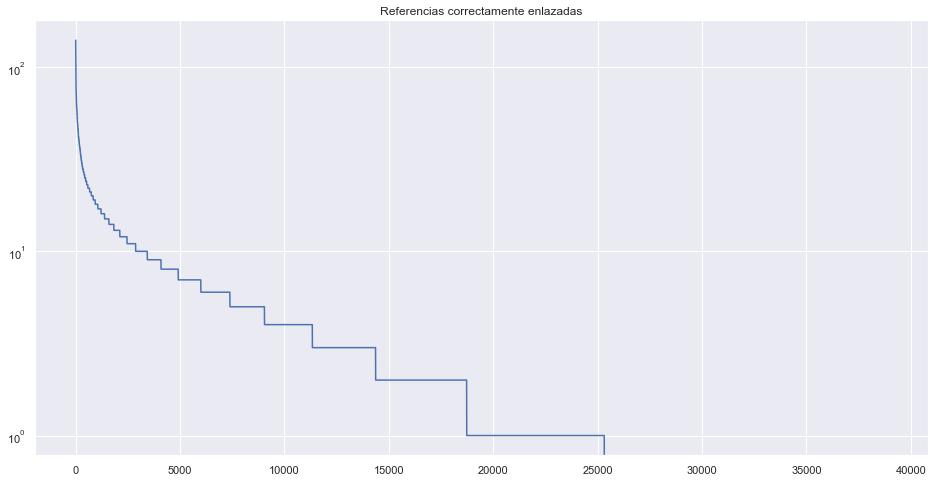

In [80]:
num_references = sorted([len(paper._references) for paper in papers], reverse=True)
num_referenced_by = sorted([len(paper._referenced_by) for paper in papers], reverse=True)
fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(y=num_references, x=range(len(papers)))
ax.set(title="Referencias de papers correctamente enlazadas", yscale="log")
pass

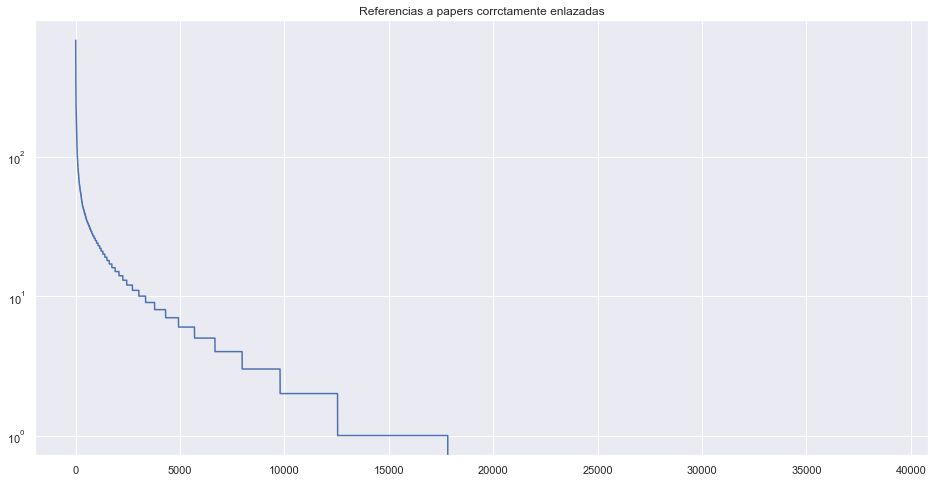

In [81]:
fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(y=num_referenced_by, x=range(len(papers)))
ax.set(title="Referencias a papers correctamente enlazadas", yscale="log")
pass

Al igual que distintos aspectos de la vida real, se ve como la cantidad de referencias correctamente enlazadas de papers siguen una distribución con cola pesada.